# Video Game Sales Prediction

## Read in the data path and libraries

In [4]:
DATA_PATH = '../notebooks/Data/vgsales/'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

##  Wrangle Function

In [3]:
def wrangle(filepath):
    # Read in the file
    df = pd.read_csv(filepath)

    # Drop all the null values
    df.dropna(inplace=True)
    
    # Set the year as the index
    df = df.sort_values('Year')
    df = df.set_index('Year')


    # Drop a unique column
    df.drop(columns=['Rank'], inplace=True)
    
    # Drop high cardinality column
    df.drop(columns=['Name'], inplace=True)
    
    # Find the top 20 values in Publisher add to a list
    top_20_publishers = df['Publisher'].value_counts()[:20].index 
    
    # Define a function that locates the publisher in the top_20_publishers list 
    # and returns the publisher's name or Other
    def top_20(publisher):
      if publisher in top_20_publishers:
        return publisher
      else:
        return 'Other'

    df['Publisher'] = df['Publisher'].apply(top_20)

    # Drop the 'leaky features'
    leaky_cols = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
    df = df.drop(columns=leaky_cols)
    
    return df
df = wrangle(DATA_PATH+'vgsales.csv')

## Split Data into Feature Matrix and Target

The target is the column Global Sales

In [9]:
target = 'Global_Sales'
X = df.drop(columns=target)
y = df[target]

## Do train/validation split by time data 

In [10]:
X_train, y_train = X.iloc[0:13291], y.iloc[0:13291] 
X_val, y_val = X.iloc[-3000:], y.iloc[-3000:]
len(X_train) + len(X_val)

16291

### Fixing the skewed dataset

Because the sales column was heavily skewed to the right I log transformed the data in it.

In [11]:
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

## Establish Baseline

In [12]:
y_log = np.log1p(y)
y_pred_log = [y_log.mean()]*len(y)
y_pred = np.expm1(y_pred_log)
print(f'Baseline Mean Absolute Error: {mean_absolute_error(y, y_pred):,.5f} million')

Baseline Mean Absolute Error: 0.51063 million


## Building Models

### Ridge

In [13]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
model_ridge = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge(alpha=1.0)
)

model_ridge.fit(X_train, y_train_log);

C:\Users\hoove\.virtualenvs\video-game-sales-app-9sM0IpHQ\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


### XGBoost Regressor Model

In [14]:
from xgboost import XGBRegressor
pipeline = make_pipeline(
    OrdinalEncoder(),
    XGBRegressor(n_jobs=-1, booster='gblinear')
)

pipeline.fit(X_train, y_train_log);

## Check Metrics

### Ridge

In [5]:
y_pred_log = model_ridge.predict(X_train)
y_pred = np.expm1(y_pred_log)
y_pred_log = model_ridge.predict(X_val)
y_pred_val = np.expm1(y_pred_log)

print(f'Ridge Regression Training MAE:  {mean_absolute_error(y_train, y_pred):,.5f} million')
print(f'Ridge Regression Validation MAE:  {mean_absolute_error(y_val, y_pred_val):,.5f} million')

NameError: name 'model_ridge' is not defined

### XGBoost

In [16]:
y_xgboost_pred_log = pipeline.predict(X_train)
y_pred_xgboost = np.expm1(y_xgboost_pred_log)
y_xgboost_pred_log = pipeline.predict(X_val)
y_pred_val_xgboost = np.expm1(y_xgboost_pred_log)

print(f'XGboost Training MAE:  {mean_absolute_error(y_train, y_pred_xgboost):,.5f} million')
print(f'XGboost Validation MAE:  {mean_absolute_error(y_val, y_pred_val_xgboost):,.5f} million')

XGboost Training MAE:  0.51015 million
XGboost Validation MAE:  0.48543 million


### The code below is for the Plotly Dash app

In [22]:
from joblib import dump
dump(pipeline, 'pipeline.joblib', compress=True)

['pipeline.joblib']

## Communication

### Coefficient ranks

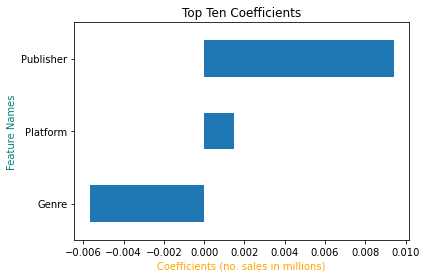

In [17]:
coefficients = pipeline.named_steps['xgbregressor'].coef_
feature_names = X_val.columns
feat_coefs = pd.Series(coefficients, index=feature_names).sort_values()
feat_coefs.tail(10).plot(kind='barh')
plt.title('Top Ten Coefficients')
plt.xlabel('Coefficients (no. sales in millions)', color='orange')
plt.ylabel('Feature Names', color='teal');

### Permutation Importances

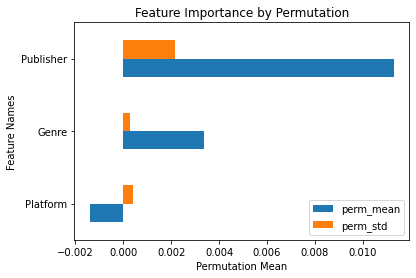

In [18]:
from sklearn.inspection import permutation_importance
perm_imps = permutation_importance(
    pipeline,
    X_val,
    y_val,
    n_repeats = 5,
    n_jobs = -1
)

perm_dict = {'perm_mean': perm_imps.importances_mean,
             'perm_std': perm_imps.importances_std}

df = pd.DataFrame(perm_dict, index=X_val.columns).sort_values('perm_mean')

df.tail(10).plot(kind='barh')
plt.xlabel('Permutation Mean')
plt.ylabel('Feature Names')
plt.title('Feature Importance by Permutation');